# How To Predict Hotel Booking Cancellation to Minimize Hotel's Financial Loss

## Background
In accommodation business, it is common for guests to cancel their booking, and some guests might cancel just before their expected check-in time. In a scenario where a hotel is fully booked, business owner might wait for the expected guest to come, and reject any other customer looking for a place to stay. This situation poses a risk that could cause financial loss if the guest called and canceled their booking, or didn't even come, and the room can't be sold anymore for that day.

What if we can predict if a guest will likely cancel their booking before their expected check-in time? If we can predict that a guest is likely going to cancel their booking, that same room can be sold to other guest. This way, we can minimize financial loss from canceled bookings, and sell those empty rooms to other potential customers.

## What is the goal?
The goal is to create a machine learning model which can predict if a guest is more likely to cancel their booking or not.

## What is the limitation?
Machine learning model can't have 100% success rate. There will be some false predictions. The model could falsely predict a booking has high chance of being canceled, but turns out the guest actually show up, and vice versa.

#### Scenario 1.
If we predicted a booking as canceled and already sold the room to other guest, but then the original guest actually come, there might be no room available for the original guest. This will hurt the hotel's reputation. The same thing applies if there is an available room, but with lower class. If the available room is a higher class, which should cost more, then the business will suffer financial loss from selling more expensive room for a cheaper price.

#### Scenario 2.
If we predicted a booking as not-canceled, but the guest didn't show up, the business will suffer financial loss because they didn't sell the room to other potential customers.

## Metrics to measure model's performance
The 2 scenarios above is called false positive and false negative prediction. And based on them, it is important that the model has low chance of giving out false predictions. The appropriate metrics to measure the performance is F1 score and AUC score.

## Dataset
For this exercies, we will use [Hotel Booking Demand dataset](https://www.kaggle.com/datasets/jessemostipak/hotel-booking-demand) from Kaggle.

Based on the information from the uploader, this dataset was originally from the article [Hotel Booking Demand Datasets](https://www.sciencedirect.com/science/article/pii/S2352340918315191) created by Nuno Antonio, Ana Almeida, and Luis Nunes for Data in Brief, Volume 22, February 2019. This dataset contains list of bookings from two hotels located in Portugal (Algrave and Lisbon). The hotels' name were classified by the original author of the dataset.

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from imblearn.over_sampling import SMOTENC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import time

In [2]:
# load the dataset
df = pd.read_csv('hotel_bookings.csv')
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


The target (y variable) on this dataset will be the 'is_canceled' column.

0 (negative class) = the booking is not canceled <br> 1 (positive class) = the booking is canceled

In [3]:
# make sure every column has matching Dtype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

# Data Cleansing

We will check if there is any booking with 0 guest.

In [4]:
# get booking's index where the booking has 0 guest
zero_guest = df[(df['adults'] == 0) & (df['children'] == 0) & (df['babies'] == 0)].index
zero_guest.shape

(180,)

Turns out there are 180 bookings with 0 guests. We will drop these bookings.

In [5]:
df.drop(index = zero_guest, inplace=True)

The column 'children' has Dtype of float64, this is because there are some null values inside those columns. We will replace those null values with 0.

In [6]:
df['children'].fillna(value=0, inplace=True)

# Exploratory Data Analysis

In [7]:
# Split dataset into training set and test set
df_train, df_test = train_test_split(df, test_size=0.2, random_state=22)

<AxesSubplot:xlabel='is_canceled', ylabel='count'>

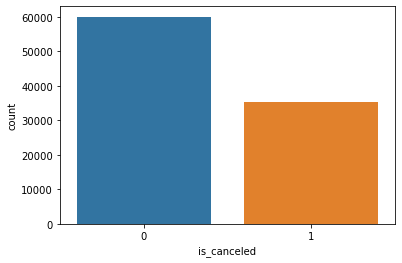

In [8]:
# countplot to see if is_canceled has balanced class distribution
sns.countplot(x='is_canceled', data=df_train)

This dataset has imbalance class.

#### Average number of bookings per year

In [9]:
# total number of bookings in dataset
num_of_bookings = df_train.shape[0]
num_of_not_canceled = df_train[df_train['is_canceled'] == 0].shape[0]
num_of_canceled = df_train[df_train['is_canceled'] == 1].shape[0]
# total weeks in dataset (we need this because the data ranges from mid 2015 to mid 2017)
total_week = df_train.groupby('arrival_date_year').nunique()['arrival_date_week_number'].sum()

# calculate average number of bookings per year
avg_yearly_bookings = (num_of_bookings / total_week) * 52
avg_yearly_bookings_not_canceled = (num_of_not_canceled / total_week) * 52
avg_yearly_bookings_canceled = (num_of_canceled / total_week) * 52
pct_avg_yearly_not_canceled = (avg_yearly_bookings_not_canceled / avg_yearly_bookings) * 100
pct_avg_yearly_canceled = (avg_yearly_bookings_canceled / avg_yearly_bookings) * 100

print('Average number of bookings per year: {:,}'.format(round(avg_yearly_bookings)))
print('Rate of bookings not canceled per year: {}%'.format(round(pct_avg_yearly_not_canceled, 2)))
print('Rate of bookings canceled per year: {}%'.format(round(pct_avg_yearly_canceled, 2)))

Average number of bookings per year: 43,123
Rate of bookings not canceled per year: 62.96%
Rate of bookings canceled per year: 37.04%


#### Check if time of the year affects number of bookings

Text(0, 0.5, 'Number of booking')

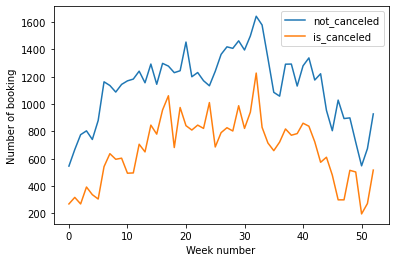

In [10]:
df_week_num_cancellation = df_train.groupby(['arrival_date_week_number', 'is_canceled']).count()
df_week_num_cancellation = df_week_num_cancellation.pivot_table(values='hotel', index='arrival_date_week_number', columns='is_canceled', fill_value=0)
df_week_num_cancellation = df_week_num_cancellation.reset_index().rename(columns={0: 'not_canceled', 1: 'is_canceled'})

sns.lineplot(x=df_week_num_cancellation.index, y='not_canceled', data=df_week_num_cancellation, label='not_canceled')
sns.lineplot(x=df_week_num_cancellation.index, y='is_canceled', data=df_week_num_cancellation, label='is_canceled')

plt.xlabel('Week number')
plt.ylabel('Number of booking')

Based on line plot above, it is clear that number of booking is higher in the middle of the year

#### Calculate financial loss from canceled bookings

ADR (Average Daily Rate) is the average price of room sold to guest on a given day.

In [11]:
avg_adr = df_train['adr'].mean()

print('Hotel ADR: EUR', round(avg_adr))

Hotel ADR: EUR 102


In [12]:
# calculate loss from canceled bookings
financial_loss = df_train[df_train['is_canceled'] == 1]['hotel'].count() * avg_adr

print('Total Loss (2015-2017): EUR {:,}'.format(round(financial_loss)))
print('Average Yearly Loss: EUR {:,}'.format(round((financial_loss/total_week)*52)))

Total Loss (2015-2017): EUR 3,600,088
Average Yearly Loss: EUR 1,627,866


### Analyse each numerical and categorical features

#### Define numerical and categorical feature to be analysed

In [13]:
num_cols = ['lead_time', 'arrival_date_week_number', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests']
ctg_cols = ['hotel', 'is_canceled', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'is_repeated_guest', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'agent', 'customer_type', 'reservation_status']

Note that we don't use some features
- arrival_date_year (time period is too short, and our goal is not time series forecasting)
- arrival_date_day_of_month (might be useful if we have holiday information)
- company (too many null values)

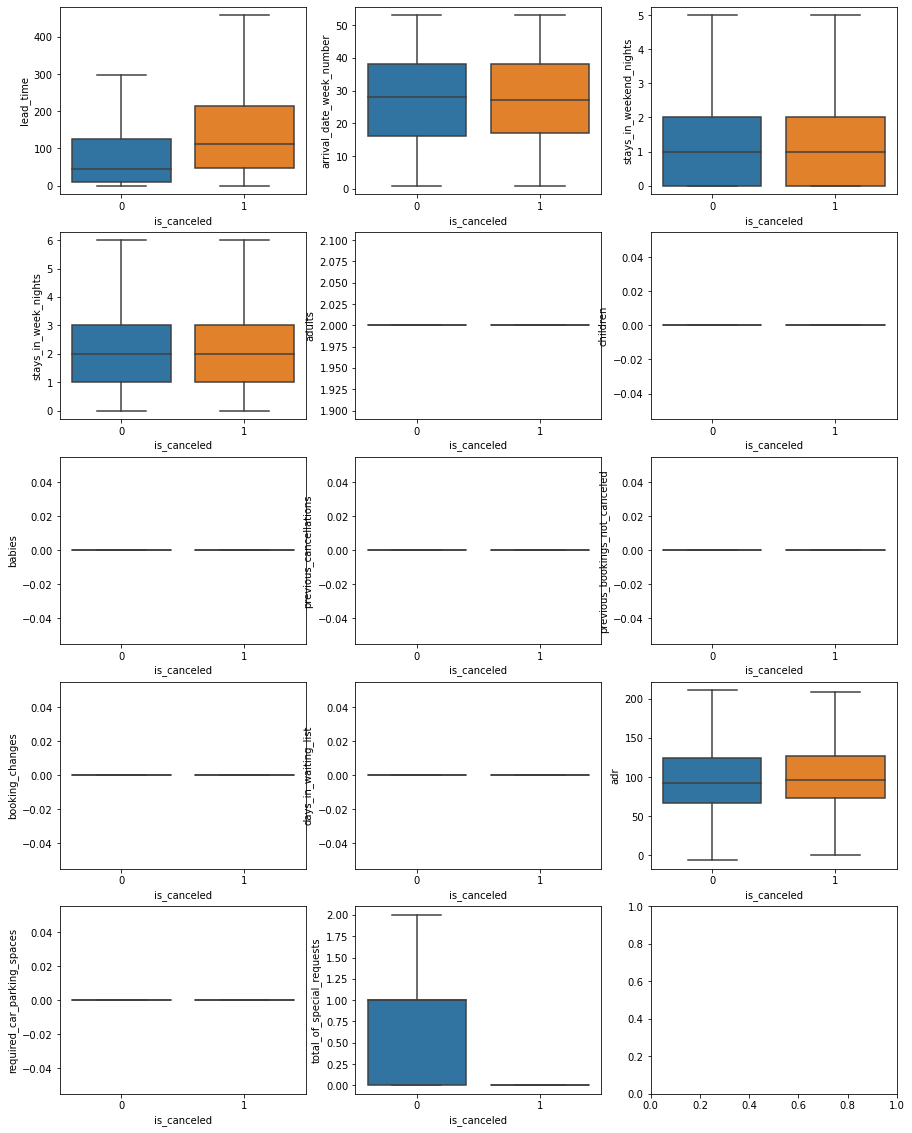

In [14]:
# plot numerical features
fig, ax = plt.subplots(5, 3, figsize=(15,20))

for ix, col in enumerate(num_cols):
    sns.boxplot(y=col, x='is_canceled', data=df_train, ax=ax.flatten()[ix], showfliers=False)

plt.show()

Based on boxplot above, only lead_time and total_of_special_requests features have noticeable difference between canceled and not-canceled.

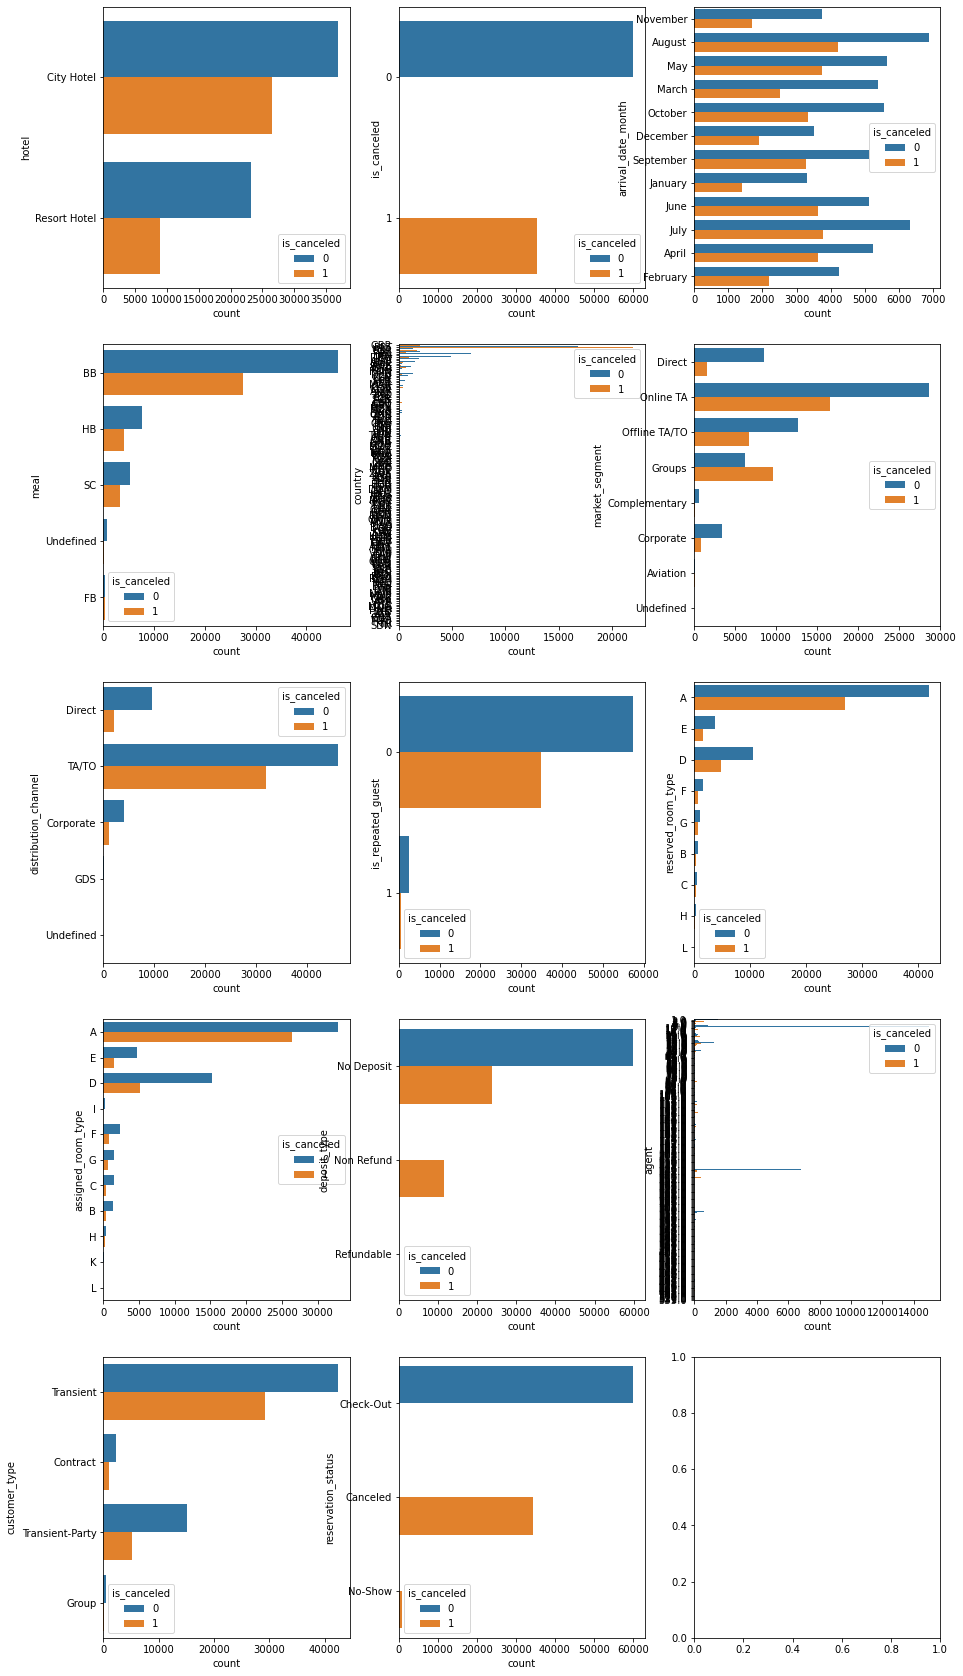

In [15]:
# plot categorical features
fig, ax = plt.subplots(5, 3, figsize=(15,30))

for ix, col in enumerate(ctg_cols):
    sns.countplot(y=col, hue='is_canceled', data=df_train, ax=ax.flatten()[ix])

plt.show()

based on countplots above, these are the features that might be used because they have big differences in some of the categories:
- hotel
- meal
- country (need further analysis because the plot isn't readable but shows some extreme values)
- market_segment
- distribution_channel
- reserved_room_type
- deposit_type
- customer_type
- agent (need further analysis because the plot isn't readable but shows some extreme values)
- is_repeated_guest

#### Hotel Guests Analysis
At data cleansing step, there are some bookings with 0 guest. We are curious to find out if there are any bookings with 0 adults but has children/babies.

In [16]:
df_train[
    (df_train['adults'] == 0) &
    ((df_train['children'] != 0) |
    (df_train['babies'] != 0) )
][['adults', 'children', 'babies']]

,adults,children,babies
64289,0,2.0,0
48233,0,2.0,0
57038,0,2.0,0
47133,0,2.0,0
65272,0,2.0,0
...,...,...,...
103635,0,2.0,0
47046,0,2.0,0
96106,0,2.0,0
79596,0,2.0,0


There are some bookings with 0 adults but has children/babies. 

#### Further analysis on country feature

In [17]:
# count total bookings from each country, and their cancelation rate
df_country = df_train.groupby(['is_canceled', 'country']).count()
df_country = df_country.pivot_table(values='hotel', index='country', columns='is_canceled', fill_value=0)
df_country = df_country.rename(columns={0: 'not_canceled', 1: 'is_canceled'})
df_country['total_bookings'] = df_country['not_canceled'] + df_country['is_canceled']
df_country['cancel_rate'] = df_country['is_canceled'] / df_country['total_bookings']
df_country[df_country['cancel_rate'] < 1].sort_values(['total_bookings', 'cancel_rate'], ascending=False).head()

is_canceled,not_canceled,is_canceled,total_bookings,cancel_rate
country,,,,
PRT,16796,22007,38803,0.567147
GBR,7724,1976,9700,0.203711
FRA,6777,1546,8323,0.185750
ESP,5110,1728,6838,0.252705
DEU,4873,973,5846,0.166439


Based on the table above, we can see PRT has the highest number of bookings, but more than half of them is canceled.

#### Further analysis on agent feature

<AxesSubplot:xlabel='count', ylabel='agent'>

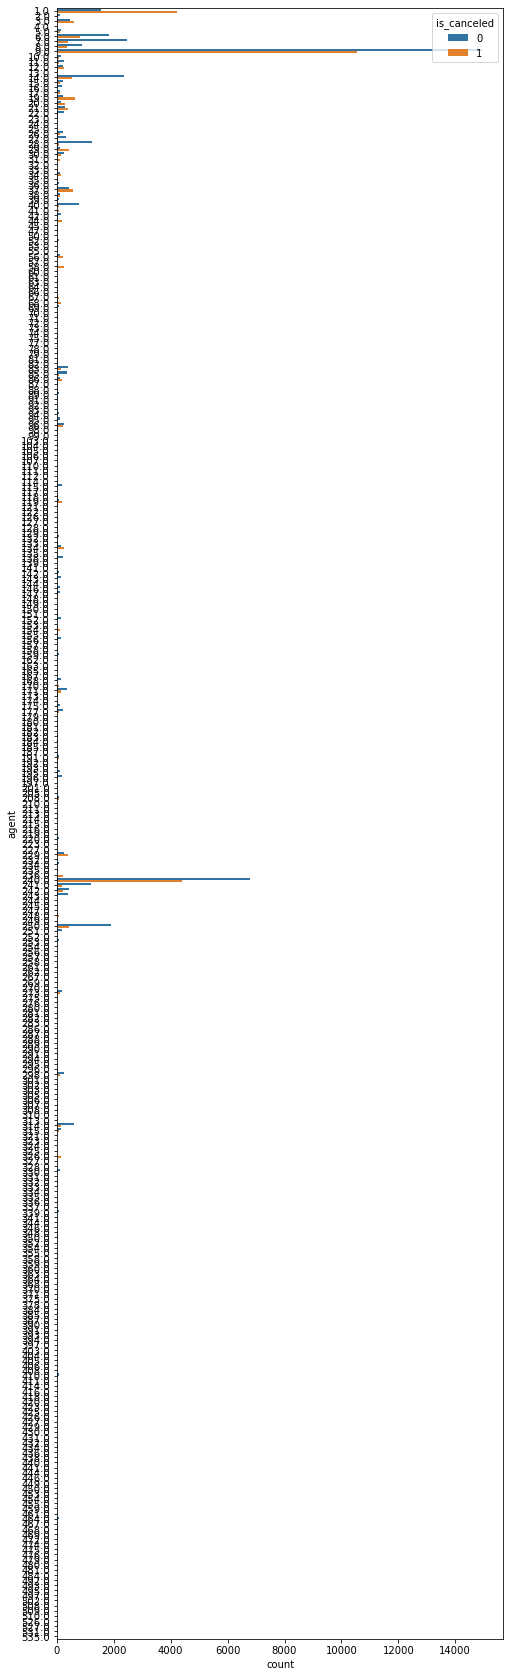

In [18]:
plt.figure(figsize=(8,30))
sns.countplot(y='agent', hue='is_canceled', data=df_train)

In [19]:
df_train.groupby(['agent', 'is_canceled']).count().sort_values(by='hotel', ascending=False)['hotel'].head(10)

agent  is_canceled
9.0    0              14942
       1              10553
240.0  0               6798
       1               4406
1.0    1               4207
7.0    0               2449
14.0   0               2358
250.0  0               1888
6.0    0               1821
1.0    0               1542
Name: hotel, dtype: int64

Based on data above, agent 1, 9, and 240 are the top 3 highest number of booking, and have high cancellation rate.

### Explore the room types feature

#### Check for available room type

In [20]:
# room type reserved by guest
df_train['reserved_room_type'].unique()

array(['A', 'E', 'D', 'F', 'G', 'B', 'C', 'H', 'L'], dtype=object)

In [21]:
# room type assigned by hotel
df_train['assigned_room_type'].unique()

array(['A', 'E', 'D', 'I', 'F', 'G', 'C', 'B', 'H', 'K', 'L'],
      dtype=object)

There are 2 room types that are not available in reserved_room_type (type 'I' and 'K').

#### Check each room's price distribution

<AxesSubplot:xlabel='reserved_room_type', ylabel='adr'>

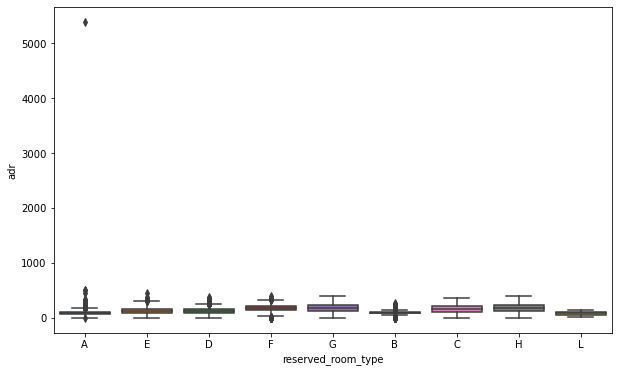

In [22]:
# plot the distribution of each room type ADR
plt.figure(figsize=(10,6))
sns.boxplot(x='reserved_room_type', y='adr', data=df_train)

Room type A has 1 extreme outlier. We will remove this data.

In [23]:
room_price_outlier = df_train[df_train['adr'] > 5000].index[0]
df_train.drop(index=room_price_outlier, inplace=True)

<AxesSubplot:xlabel='reserved_room_type', ylabel='adr'>

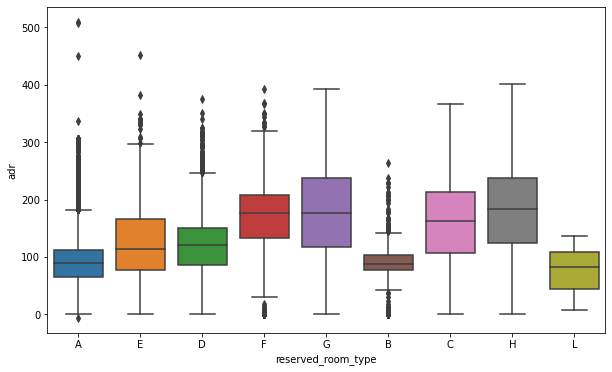

In [24]:
# plot the distribution of each room type ADR after removing extreme outlier
plt.figure(figsize=(10,6))
sns.boxplot(x='reserved_room_type', y='adr', data=df_train)

Each room type has different ADR distribution.

#### Rank each reserved room type based on their average ADR

Assumption: ADR is the price of reserved_room_type (the price at the time when guest booked the hotel), not the price of assigned_room_type (room assigned by the hotel).

We will calculate the average price of each room type based on reserved_room_type to find out which room type is more expensive.

Based on assumption above, we can't calculate the average price of room type 'I' and 'K' because there are no bookings with those reserved room type.

In [25]:
# calculate average ADR for each room type
df_mean_adr = pd.DataFrame(df_train.groupby('reserved_room_type')['adr'].mean().sort_values()).reset_index().rename(columns={'reserved_room_type': 'room_type'})
df_mean_adr

,room_type,adr
0,L,75.333333
1,B,90.197643
2,A,90.854180
3,D,120.765036
4,E,124.267114
5,C,160.144179
6,F,167.812154
7,G,175.808208
8,H,187.078241


We create a dictionary of room types and ranks pair to rank every booked and assigned room types. 

In [26]:
# create a room type ranking dictionary
room_type_rank_dict = {}

for room_type in df_mean_adr['room_type']:
    ix = df_mean_adr[df_mean_adr['room_type'] == room_type].index
    room_type_rank_dict[room_type] = ix[0]
    
room_type_rank_dict

{'L': 0, 'B': 1, 'A': 2, 'D': 3, 'E': 4, 'C': 5, 'F': 6, 'G': 7, 'H': 8}

We will give each booking's room a rank based on the dictionary

In [27]:
# select only the reserved and assigned room type of each bookings
df_reserved_assigned_room_pair = df_train[['is_canceled', 'reserved_room_type', 'assigned_room_type']]
df_reserved_assigned_room_pair

,is_canceled,reserved_room_type,assigned_room_type
101250,0,A,A
41642,1,A,A
89106,0,A,A
89379,0,E,E
108447,0,A,A
...,...,...,...
88641,0,A,A
24939,0,E,F
31687,0,D,D
95108,0,D,D


In [28]:
# create a function to encode each room's rank based on room_type_rank_dict.
# For room type 'I' and 'K', we will give them a different value.
def room_type_ranker(room_type):
    if (room_type in room_type_rank_dict):
        return room_type_rank_dict[room_type]
    else:
        # for room type 'I' and 'K'
        return len(room_type_rank_dict)

In [29]:
# applying the room_type_ranker function
df_reserved_assigned_room_pair['reserved_room_type_rank'] = df_reserved_assigned_room_pair['reserved_room_type'].apply(room_type_ranker)
df_reserved_assigned_room_pair['assigned_room_type_rank'] = df_reserved_assigned_room_pair['assigned_room_type'].apply(room_type_ranker)
df_reserved_assigned_room_pair

<ipython-input-29-ffc0d5147fef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reserved_assigned_room_pair['reserved_room_type_rank'] = df_reserved_assigned_room_pair['reserved_room_type'].apply(room_type_ranker)
<ipython-input-29-ffc0d5147fef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reserved_assigned_room_pair['assigned_room_type_rank'] = df_reserved_assigned_room_pair['assigned_room_type'].apply(room_type_ranker)


,is_canceled,reserved_room_type,assigned_room_type,reserved_room_type_rank,assigned_room_type_rank
101250,0,A,A,2,2
41642,1,A,A,2,2
89106,0,A,A,2,2
89379,0,E,E,4,4
108447,0,A,A,2,2
...,...,...,...,...,...
88641,0,A,A,2,2
24939,0,E,F,4,6
31687,0,D,D,3,3
95108,0,D,D,3,3


We will calculate the financial loss suffered by the hotel if they assigned a guest to a higher ranked room.

In [30]:
# select only bookings with different reserved and assigned room, and exclude room type 'I' and 'K'.
df_different_room_type = df_reserved_assigned_room_pair[
    (df_reserved_assigned_room_pair['reserved_room_type'] != df_reserved_assigned_room_pair['assigned_room_type']) &
    (df_reserved_assigned_room_pair['assigned_room_type_rank'] != 9)]
df_different_room_type

,is_canceled,reserved_room_type,assigned_room_type,reserved_room_type_rank,assigned_room_type_rank
2479,0,A,D,2,3
44049,0,A,D,2,3
82611,0,A,D,2,3
21701,0,A,D,2,3
18480,0,A,D,2,3
...,...,...,...,...,...
29941,0,A,D,2,3
43751,0,A,D,2,3
105120,0,A,D,2,3
20978,0,A,E,2,4


In [31]:
# select bookings with higher assigned room's rank than reserved room's rank
df_higher_room_assigned = pd.DataFrame(df_different_room_type[df_different_room_type['assigned_room_type_rank'] > df_different_room_type['reserved_room_type_rank']].groupby(['reserved_room_type', 'assigned_room_type']).count()['reserved_room_type_rank'].reset_index().rename(columns={'reserved_room_type_rank': 'count'}))

# insert price for each reserved and assigned room type
df_higher_room_assigned = df_higher_room_assigned.merge(right=df_mean_adr, how='inner', left_on='reserved_room_type', right_on='room_type')
df_higher_room_assigned = df_higher_room_assigned.merge(right=df_mean_adr, how='inner', left_on='assigned_room_type', right_on='room_type')
df_higher_room_assigned.drop(columns=['room_type_x', 'room_type_y'], inplace=True)
df_higher_room_assigned.rename(columns={'adr_x': 'reserved_room_price', 'adr_y': 'assigned_room_price'}, inplace=True)

# calculate loss from assigning higher room type to a booking with cheaper reserved room
df_higher_room_assigned['price_diff'] = df_higher_room_assigned['assigned_room_price'] - df_higher_room_assigned['reserved_room_price']
df_higher_room_assigned['total_price_diff'] = df_higher_room_assigned['price_diff'] * df_higher_room_assigned['count']
df_higher_room_assigned.sort_values(by=['reserved_room_type', 'assigned_room_type'])

,reserved_room_type,assigned_room_type,count,reserved_room_price,assigned_room_price,price_diff,total_price_diff
0,A,C,1162,90.854180,160.144179,69.289999,80514.978696
4,A,D,6069,90.854180,120.765036,29.910856,181528.986694
6,A,E,932,90.854180,124.267114,33.412934,31140.854888
9,A,F,339,90.854180,167.812154,76.957974,26088.753057
14,A,G,156,90.854180,175.808208,84.954028,13252.828389
20,A,H,78,90.854180,187.078241,96.224061,7505.476780
26,B,A,99,90.197643,90.854180,0.656537,64.997211
5,B,D,4,90.197643,120.765036,30.567394,122.269575
7,B,E,1,90.197643,124.267114,34.069472,34.069472
10,B,F,1,90.197643,167.812154,77.614511,77.614511


In [32]:
# calculate overall loss and average loss per booking
total_loss = round(df_higher_room_assigned['total_price_diff'].sum())
avg_loss = round(df_higher_room_assigned['total_price_diff'].sum()/df_higher_room_assigned['count'].sum())

print('Financial loss from assigning higher room type than reserved room type')
print('Total loss: EUR {:,}'.format(total_loss))
print('Average loss per room: EUR {:,}'.format(avg_loss))

Financial loss from assigning higher room type than reserved room type
Total loss: EUR 375,980
Average loss per room: EUR 37


We will calculate the financial surplus if hotel assigned a guest to a lower ranked room.

In [33]:
# select bookings with lower assigned room's rank than reserved room's rank
df_lower_room_assigned = pd.DataFrame(df_different_room_type[df_different_room_type['assigned_room_type_rank'] < df_different_room_type['reserved_room_type_rank']].groupby(['reserved_room_type', 'assigned_room_type']).count()['reserved_room_type_rank'].reset_index().rename(columns={'reserved_room_type_rank': 'count'}))

# insert price for each reserved and assigned room type
df_lower_room_assigned = df_lower_room_assigned.merge(right=df_mean_adr, how='inner', left_on='reserved_room_type', right_on='room_type')
df_lower_room_assigned = df_lower_room_assigned.merge(right=df_mean_adr, how='inner', left_on='assigned_room_type', right_on='room_type')
df_lower_room_assigned.drop(columns=['room_type_x', 'room_type_y'], inplace=True)
df_lower_room_assigned.rename(columns={'adr_x': 'reserved_room_price', 'adr_y': 'assigned_room_price'}, inplace=True)

# calculate loss from assigning higher room type to a booking with cheaper reserved room
df_lower_room_assigned['price_diff'] = df_lower_room_assigned['assigned_room_price'] - df_lower_room_assigned['reserved_room_price']
df_lower_room_assigned['total_price_diff'] = df_lower_room_assigned['price_diff'] * df_lower_room_assigned['count']
df_lower_room_assigned.sort_values(by=['reserved_room_type', 'assigned_room_type'])

,reserved_room_type,assigned_room_type,count,reserved_room_price,assigned_room_price,price_diff,total_price_diff
0,A,B,898,90.854180,90.197643,-0.656537,-589.570660
6,C,A,4,160.144179,90.854180,-69.289999,-277.159996
1,C,B,2,160.144179,90.197643,-69.946536,-139.893073
11,C,D,6,160.144179,120.765036,-39.379143,-236.274856
15,C,E,4,160.144179,124.267114,-35.877064,-143.508258
7,D,A,242,120.765036,90.854180,-29.910856,-7238.427217
2,D,B,21,120.765036,90.197643,-30.567394,-641.915269
8,E,A,12,124.267114,90.854180,-33.412934,-400.955213
3,E,B,2,124.267114,90.197643,-34.069472,-68.138944
12,E,D,16,124.267114,120.765036,-3.502078,-56.033251


In [34]:
# calculate overall surplus and average surplus per booking
total_surplus = round(df_lower_room_assigned['total_price_diff'].sum())
avg_surplus = round(df_lower_room_assigned['total_price_diff'].sum()/df_lower_room_assigned['count'].sum())

print('Surplus from assigning higher room type than reserved room type')
print('Total surplus: EUR {:,}'.format(total_surplus))
print('Average surplus per room: EUR {:,}'.format(avg_surplus))

Surplus from assigning higher room type than reserved room type
Total surplus: EUR -13,231
Average surplus per room: EUR -10


Calculate percentage of bookings that were assigned to lower and higher class room

In [35]:
# count total booking with diiferent room assigned.
total_diff_room_type = df_different_room_type.shape[0]

In [36]:
# calculate percentage of bookings that were assigned to a lower class room, and is canceled
num_lower_assigned_canceled = df_different_room_type[
    (df_different_room_type['is_canceled'] == 1) &
    (df_different_room_type['assigned_room_type_rank'] > df_different_room_type['reserved_room_type_rank'])
].count()['is_canceled']

pct_lower_assigned_canceled = round((num_lower_assigned_canceled/total_diff_room_type*100), 2)
print("Percentage of booking that is assigned to a lower class room and is canceled: {}%".format(pct_lower_assigned_canceled))

Percentage of booking that is assigned to a lower class room and is canceled: 4.31%


In [37]:
# calculate percentage of bookings that were assigned to a lower class room, and not canceled
num_lower_assigned_not_canceled = df_different_room_type[
    (df_different_room_type['is_canceled'] == 0) &
    (df_different_room_type['assigned_room_type_rank'] > df_different_room_type['reserved_room_type_rank'])
].count()['is_canceled']

pct_lower_assigned_not_canceled = round((num_lower_assigned_not_canceled/total_diff_room_type*100), 2)
print("Percentage of booking that is assigned to a lower class room and not canceled: {}%".format(pct_lower_assigned_not_canceled))

Percentage of booking that is assigned to a lower class room and not canceled: 84.51%


In [38]:
# calculate percentage of bookings that were assigned to a higher class room, and is canceled
num_higher_assigned_canceled = df_different_room_type[
    (df_different_room_type['is_canceled'] == 1) &
    (df_different_room_type['assigned_room_type_rank'] < df_different_room_type['reserved_room_type_rank'])
].count()['is_canceled']

pct_higher_assigned_canceled = round((num_higher_assigned_canceled/total_diff_room_type*100), 2)
print("Percentage of booking that is assigned to a higher class room and is canceled: {}%".format(pct_higher_assigned_canceled))

Percentage of booking that is assigned to a higher class room and is canceled: 1.1%


In [39]:
# calculate percentage of bookings that were assigned to a higher class room, and not canceled
num_higher_assigned_not_canceled = df_different_room_type[
    (df_different_room_type['is_canceled'] == 0) &
    (df_different_room_type['assigned_room_type_rank'] < df_different_room_type['reserved_room_type_rank'])
].count()['is_canceled']

pct_higher_assigned_not_canceled = round((num_higher_assigned_not_canceled/total_diff_room_type*100), 2)
print("Percentage of booking that is assigned to a higher class room and not canceled: {}%".format(pct_higher_assigned_not_canceled))

Percentage of booking that is assigned to a higher class room and not canceled: 10.07%


#### Check for correlation coefficient from each numerical features to the target is_canceled

In [40]:
corr_coef = df_train.corr()
abs(corr_coef['is_canceled']).sort_values(ascending=False).head(6)

is_canceled                    1.000000
lead_time                      0.290579
total_of_special_requests      0.234161
required_car_parking_spaces    0.195163
booking_changes                0.146888
previous_cancellations         0.110142
Name: is_canceled, dtype: float64

From the heatmap above, 5 features with strongest correlation coefficient toward is_canceled are:
- lead_time
- total_of_special_requests
- required_car_parking_spaces (assumed parking spaces required by a customer was asked on booking)
- booking_changes
- previous_cancellation

### Features to be Used
Based on the analysis above, here are the features that will be used to train the machine learning model:
- lead_time
- arrival_date_week_number
- previous_cancellation
- booking_changes
- required_car_parking_spaces
- total_of_special_requests
- hotel
- meal
- country
- market_segment
- distribution_channel
- is_repeated_guest
- reserved_room_type
- agent
- customer_type

### To-dos:

- create new column total_stay_duration to store sum of week nights and weekend nights
- divide meal into BB and Other
- divide country into PRT and Other
- divide market_segment into Online TA, Direct, Offline TA/TO, Groups, Corporate, and Other
- divide distribution_channel into TA/TO, Direct, Corporate, and Other
- divide reserved_room_type into A, D, E and Other

# Data Preprocessing

#### Define some functions to encode data

In [41]:
def meal_encoder(meal):
    if (meal != 'BB'):
        meal = 'Other'
    return meal

def country_encoder(country):
    if (country != 'PRT'):
        country = 'Other'
    return country

def market_segment_encoder(market_segment):
    if (market_segment == 'Complementary')  or (market_segment == 'Aviation') or (market_segment == 'Undefined'):
        market_segment = 'Other'
    return market_segment

def distribution_channel_encoder(distribution_channel):
    if (distribution_channel == 'GDS') or (distribution_channel == 'Undefined'):
        distribution_channel = 'Other'
    return distribution_channel

def reserved_room_encoder(reserved_room_type):
    if (reserved_room_type != 'A') and (reserved_room_type != 'D') and (reserved_room_type != 'E'):
        reserved_room_type = 'Other'
    return reserved_room_type

def agent_encoder(agent):
    if (agent != 1) and (agent != 9) and (agent != 240):
        agent = 0
    return agent

In [42]:
df_train['meal_encoded'] = df_train['meal'].apply(meal_encoder)
df_test['meal_encoded'] = df_test['meal'].apply(meal_encoder)

df_train['country_encoded'] = df_train['country'].apply(country_encoder)
df_test['country_encoded'] = df_test['country'].apply(country_encoder)

df_train['market_segment_encoded'] = df_train['market_segment'].apply(market_segment_encoder)
df_test['market_segment_encoded'] = df_test['market_segment'].apply(market_segment_encoder)

df_train['distribution_channel_encoded'] = df_train['distribution_channel'].apply(distribution_channel_encoder)
df_test['distribution_channel_encoded'] = df_test['distribution_channel'].apply(distribution_channel_encoder)

df_train['reserved_room_type_encoded'] = df_train['reserved_room_type'].apply(reserved_room_encoder)
df_test['reserved_room_type_encoded'] = df_test['reserved_room_type'].apply(reserved_room_encoder)

df_train['agent_encoded'] = df_train['agent'].apply(agent_encoder)
df_test['agent_encoded'] = df_test['agent'].apply(agent_encoder)

In [43]:
# define columns to be used
used_num_cols = ['lead_time', 'arrival_date_week_number', 'previous_cancellations', 'booking_changes', 'required_car_parking_spaces', 'total_of_special_requests']
used_ctg_cols_encoded = ['hotel', 'meal_encoded', 'country_encoded', 'market_segment_encoded', 'distribution_channel_encoded', 'is_repeated_guest', 'reserved_room_type_encoded', 'agent_encoded', 'customer_type']

In [44]:
# define OneHotEncoder to encode categorical columns
onehot_encoder = OneHotEncoder()
# define empty FunctionTransformer for numerical columns
do_nothing = FunctionTransformer()
# combine OneHotEncoder and FunctionTransformer in ColumnTransformer to be used in pipeline
col_transformer = ColumnTransformer([
    ('encoder', onehot_encoder, used_ctg_cols_encoded),
    ('do_nothing', do_nothing, used_num_cols)
])

In [45]:
# define feature and target dataset
X_train = df_train[used_num_cols + used_ctg_cols_encoded]
X_test = df_test[used_num_cols + used_ctg_cols_encoded]
y_train = df_train['is_canceled']
y_test = df_test['is_canceled']

# Model Training

#### Create a function to run model fitting and calculate model performances.

In [46]:
# define a dataframe to store model's performance
df_model_score = pd.DataFrame(columns=['Model', 'Precision', 'Recall', 'F1', 'AUC', 'Confusion Matrix'])

In [47]:
def model_eval(estimator, estimator_name, train_feature, train_target, test_feature, test_target):
    # create empty list to store metrics, this will be used to compare the performance of each model
    metric_val = []
    
    # append model's name to metric_val
    metric_val.append(estimator_name)
    
    # fit train set to model
    estimator.fit(train_feature, train_target)
    
    # define metrics to be used for calculating cross validation score
    metrics = ['precision', 'recall', 'f1']
    
    # calculate metrics with cross validation
    for metric in metrics:
        val = cross_val_score(estimator, train_feature, train_target, scoring=metric, cv=5).mean()
        # append cross validation score to metric_val
        metric_val.append(val)

    # predict probability of test set for ROC-AUC
    y_pred_proba = estimator.predict_proba(test_feature)[::,1]
    # calculate AUC
    auc = roc_auc_score(test_target, y_pred_proba)
    # append AUC score
    metric_val.append(auc)
    
    # predict test set
    y_pred = estimator.predict(test_feature)
    # calculate confision matrix
    conf = confusion_matrix(test_target, y_pred)
    metric_val.append(conf)
    
    # append cross validation score to df_model_score
    df_len = len(df_model_score)
    df_model_score.loc[df_len] = metric_val

## Base Model
For the base model, we will train:
- Logistic Regression
- Decision Tree

#### Model initialization

In [48]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=3000)

log_reg_pipeline = Pipeline([
    ('smotenc', SMOTENC(random_state=22, categorical_features=range(6,15))),
    ('col_transformer', col_transformer),
    ('log_reg', log_reg)
])

# Decision Tree
dt = DecisionTreeClassifier(random_state=22)

dt_pipeline = Pipeline([
    ('smotenc', SMOTENC(random_state=22, categorical_features=range(6,15))),
    ('col_transformer', col_transformer),
    ('dt', dt)
])

base_models = {'Logistic Regression': log_reg_pipeline, 
               'Decision Tree': dt_pipeline}

In [49]:
# loop through base_models to train and evaluate each models
for model_name, model in base_models.items():
    model_eval(model, model_name, X_train, y_train, X_test, y_test)

# base models' performances
df_model_score.sort_values(by='F1', ascending=False)

,Model,Precision,Recall,F1,AUC,Confusion Matrix
1,Decision Tree,0.770246,0.805544,0.787494,0.841689,"[[12901, 2062], [1719, 7160]]"
0,Logistic Regression,0.700071,0.786744,0.740856,0.881703,"[[11998, 2965], [1881, 6998]]"


## Ensemble Model
For the ensemble model, we will train:
- Random Forest
- Voting Classifier
- Light Gradient Boosting Machine

#### Model Initialization

In [50]:
# Random Forest
rf = RandomForestClassifier(random_state=22)

rf_pipeline = Pipeline([
    ('smotenc', SMOTENC(random_state=22, categorical_features=range(6,15))),
    ('col_transformer', col_transformer),
    ('rf', rf)
])

# Voting Classifier
voting = VotingClassifier(estimators=[('lr', log_reg), ('dt', dt)], voting='soft')

voting_pipeline = Pipeline([
    ('smotenc', SMOTENC(random_state=22, categorical_features=range(6,15))),
    ('col_transformer', col_transformer),
    ('voting', voting)
])

# Light Gradient Boosting Machine
lgbm = LGBMClassifier()

lgbm_pipeline = Pipeline([
    ('smotenc', SMOTENC(random_state=22, categorical_features=range(6,15))),
    ('col_transformer', col_transformer),
    ('lgbm', lgbm)
])

ensemble_models = {'Random Forest': rf_pipeline, 
                   'Voting Classifier': voting_pipeline,
                  'Light Gradient Boosting Machine': lgbm_pipeline}

In [51]:
# loop through ensemble_models to train and evaluate each models
for model_name, model in ensemble_models.items():
    model_eval(model, model_name, X_train, y_train, X_test, y_test)

# ensemble models' performances
df_model_score.sort_values(by='F1', ascending=False)

,Model,Precision,Recall,F1,AUC,Confusion Matrix
2,Random Forest,0.803111,0.827600,0.815167,0.936799,"[[13136, 1827], [1517, 7362]]"
4,Light Gradient Boosting Machine,0.773510,0.832923,0.802087,0.934949,"[[12748, 2215], [1404, 7475]]"
3,Voting Classifier,0.764510,0.812424,0.787733,0.916866,"[[12825, 2138], [1656, 7223]]"
1,Decision Tree,0.770246,0.805544,0.787494,0.841689,"[[12901, 2062], [1719, 7160]]"
0,Logistic Regression,0.700071,0.786744,0.740856,0.881703,"[[11998, 2965], [1881, 6998]]"


## Ensemble Model Hyperparameter Tuning

#### Random Forest

In [52]:
# define parameter grid for tuning random forest model
rf_param_grid = {
    'rf__n_estimators': [100],
    'rf__max_depth': [30]
}

# initialize grid search to find best hyperparameter combination
rf_grid_search = GridSearchCV(
    estimator=rf_pipeline,
    param_grid=rf_param_grid
)

# run grid search
rf_grid_search.fit(X_train, y_train)

# get best random forest model from grid search
rf_best = rf_grid_search.best_estimator_

# run model_eval on best random forest model
model_eval(rf_best, 'Best Random Forest', X_train, y_train, X_test, y_test)

#### Random Forest Feature Importances

C:\Users\alber\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


<AxesSubplot:xlabel='feature_importances', ylabel='feature_names'>

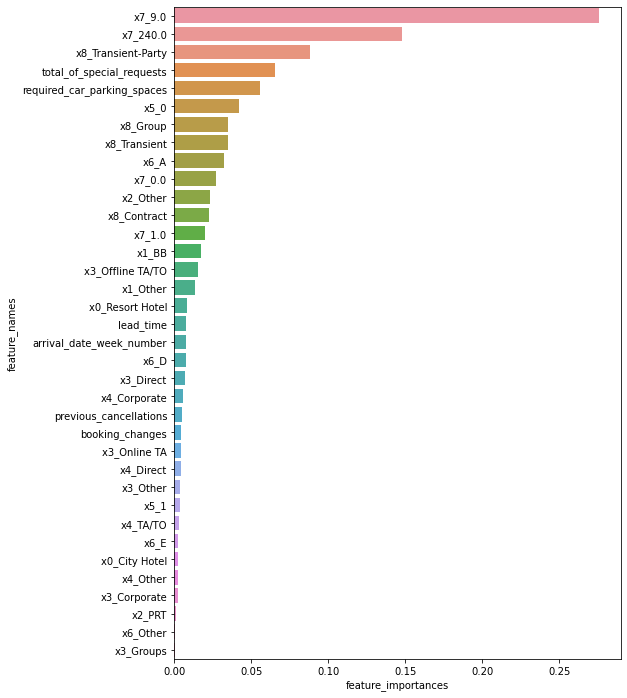

In [53]:
# get feature importances
rf_feature_importances = rf_best.steps[2][1].feature_importances_

# get onehot encoded feature names
ctg_onehot = onehot_encoder.fit_transform(X_train[used_ctg_cols_encoded])
feature_names = np.concatenate((used_num_cols, onehot_encoder.get_feature_names()))

# create dataframe to store feature importances
d = {'feature_names': feature_names, 'feature_importances': rf_feature_importances}
df_feature_importances = pd.DataFrame(data=d)

# plot feature importances
plt.figure(figsize=(8,12))
sns.barplot(x='feature_importances', y='feature_names', data=df_feature_importances, order=df_feature_importances.sort_values(by='feature_importances', ascending=False)['feature_names'])

#### Evaluate all models' performances

In [54]:
df_model_score.sort_values(by='F1', ascending=False)

,Model,Precision,Recall,F1,AUC,Confusion Matrix
5,Best Random Forest,0.802581,0.832300,0.817166,0.940645,"[[13161, 1802], [1476, 7403]]"
2,Random Forest,0.803111,0.827600,0.815167,0.936799,"[[13136, 1827], [1517, 7362]]"
4,Light Gradient Boosting Machine,0.773510,0.832923,0.802087,0.934949,"[[12748, 2215], [1404, 7475]]"
3,Voting Classifier,0.764510,0.812424,0.787733,0.916866,"[[12825, 2138], [1656, 7223]]"
1,Decision Tree,0.770246,0.805544,0.787494,0.841689,"[[12901, 2062], [1719, 7160]]"
0,Logistic Regression,0.700071,0.786744,0.740856,0.881703,"[[11998, 2965], [1881, 6998]]"


In [55]:
df_model_score.sort_values(by='AUC', ascending=False)

,Model,Precision,Recall,F1,AUC,Confusion Matrix
5,Best Random Forest,0.802581,0.832300,0.817166,0.940645,"[[13161, 1802], [1476, 7403]]"
2,Random Forest,0.803111,0.827600,0.815167,0.936799,"[[13136, 1827], [1517, 7362]]"
4,Light Gradient Boosting Machine,0.773510,0.832923,0.802087,0.934949,"[[12748, 2215], [1404, 7475]]"
3,Voting Classifier,0.764510,0.812424,0.787733,0.916866,"[[12825, 2138], [1656, 7223]]"
0,Logistic Regression,0.700071,0.786744,0.740856,0.881703,"[[11998, 2965], [1881, 6998]]"
1,Decision Tree,0.770246,0.805544,0.787494,0.841689,"[[12901, 2062], [1719, 7160]]"


Based on tables above, our best model is Random Forest after Hyperparameter Tuning.

## Conclusion
- Based on experiments above, the best machine learning model is Random Forest with Hyperparameter Tuning with performance as following.
1. Precision: 80.26%, which means out of all predictions, 80.26% of them are correct.
2. Recall: 83.23%, which means out of all data, 83.23% of them are classified correctly.
3. F1: 81.72%, the average of precision and recall.
4. AUC ROC: 94.06%, which means the model has 94% chance of correctly classifying the data

- If we implemented this model, we could estimate an additional revenue of 43,123 x 37.04% x 80.26% x EUR 102 = **EUR 1,307,613/year** from correctly predicting which booking will be canceled and resell all of those rooms.


- Here are the top 5 features that have the most impact on prediction
1. Agent that is used by the customer (especially agent 9 and 240)
2. Customer type (especially if the customer is transient party)
3. Total number of special requests made by the customer (higher number of special requests, lower cancellation probability)
4. Car parking spaces required by the customer (higher number of special requests, lower cancellation probability)
5. The customer is not a repeated guest

## Recommendation
### Recommendation for business owner
Here is our recommendation for business owner when we get a false prediction with some assumptions.
#### Assumptions based on analysis
- Avg. yearly bookings: 43,123
- Avg. room price = EUR 102
- Pct. of hotel fully booked: 10%
- Pct. of assigning lower class room and is canceled: 4.31%
- Pct. of assigning lower class room and not canceled: 84.51%
- Pct. of assigning higher class room: 11.18%
- Avg. loss from assigning higher class room: EUR 37
- Avg. surplus from assigning lower class room: EUR 10
- Rate of falsely predict a booking as canceled: 100% - Precision = 19.74%
- Rate of falsely predict a booking as not canceled: 100% - Recall = 16.77%

#### Recommendations
1. If a booking is predicted as canceled and the room already sold, but the customer show up. This has several scenarios.
    - No room available: refund any payment already made, and offer a voucher e.g. worth 1 night of stay. We don't have any information on how often the hotel is fully booked, so we will make an assumption of 10%. Estimated cost of giving out voucher: 43,123 x 19.74% x 10% x EUR 102 = **EUR 86,827/year**.
    - Lower class room available but customer reject room changes: refund any payment already made, and offer a voucher e.g. worth 1 night of stay. Estimated cost of giving out voucher: 43,123 x 19.74% x 90% x 4.31% x EUR 102 = **EUR 33,680/year**.
    - Lower class room available and customer accept room changes: offer a voucher e.g. worth the difference between assigned room price and reserved room price. Estimated cost of giving out voucher: 43,123 x 19.74% x 90% x 84.51% x EUR 10 = **EUR 64,745/year**.
    - Higher class room available: assign the customer to a higher class room. Estimated cost: 43,123 x 19.74% x 90% x 11.18% x EUR 37 = **EUR 31,691/year**.


2. If a booking is predicted as not canceled but the customer didn't show up and the room can't be sold for that same day.
    - Ask customer for down payment if possible (e.g. 50% down payment, non-refundable if customer canceled). Estimated loss from not being able to sold a room: 43,123 x 16.77% x EUR 102 x 50% = **EUR 368,818/year**.
    - Emphasize on cancellation policy that any payment made can not be refunded if customer cancelled their booking (for deposit type of non-refund).
    
3. To minimize bookings cancelation, we could set a special rate for advance booking, but with non-refundable payment.

### Recommendation for operational
Because our best model still has probability to give a false prediction, we shouldn't immediately take action (especially if a booking is predicted as canceled but with low probability). Here are some recommendations when such condition occurs:
1. Remind the customer that they have booked a room in our hotel (e.g. via email or text messages).
2. Call the customer to make sure whether they still want to keep their booking or not.

### Recommendation for other researcher
1. Do error analysis to find out what causes false predictions. 
2. Experiment other kind of feature engineering.
3. Try other feature combinations.